In [5]:
import torch as torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm
import os
import time 
import torch.optim as optim
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
%pip install einops
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from einops import rearrange

if not torch.cuda.is_available():
  print('Not connected to a GPU')
print(device)


Note: you may need to restart the kernel to use updated packages.
cuda


In [15]:

def split_sample(train_data, m, user):
    a=int(user*m)
    b=int((user+1)*m)
    train_set=Data.Subset(train_data,range(a,b))
    return train_set
test_data=Data.Subset(torchvision.datasets.MNIST(root='./MINIST',transform = torchvision.transforms.ToTensor(),train=False),range(0,2000))
test_x,test_y=zip(*[item for item in test_data])
test_x=torch.stack(test_x).type(torch.FloatTensor)/255.
test_y=torch.tensor(test_y)

In [19]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output = nn.Linear(32*7*7,10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out=out.flatten(start_dim=1)
        #out = out.view(out.size(0),-1)
        out = self.output(out)
        return out


In [25]:


BATCH_SIZE= 50
LR= 0.001
EPOCH =  3
train_data = torchvision.datasets.MNIST(
    root = './MINIST',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download=True
)

train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=os.cpu_count(),prefetch_factor=3,pin_memory=True)


cnn = CNN()
cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR,)
loss_func = nn.CrossEntropyLoss()



for epoch in range(EPOCH):
    loader=tqdm(train_loader)
    for step ,(b_x,b_y) in enumerate(loader):
        b_x = b_x.to(device,non_blocking=True)
        b_y = b_y.to(device,non_blocking=True)
        output = cnn(b_x)
        loss = loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%50 ==0:
            with torch.no_grad():
                test_output = cnn(test_x.to(device,non_blocking=True))
                pred_y = torch.max(test_output, 1)[1].cpu()
                accuracy = (pred_y == test_y).sum() / test_y.shape[0]
                loader.set_description(f'Epoch:{epoch}|Step:{step}|Loss:{loss.item():.4f}|Acc:{accuracy:.2%}')
    torch.save(cnn,'cnn_minist.pkl')


Epoch:2|Step:1150|Loss:0.0670|Acc:11.70%:   0%|          | 0/1200 [02:09<?, ?it/s]
Epoch:0|Step:1150|Loss:0.0504|Acc:11.70%: 100%|██████████| 1200/1200 [00:02<00:00, 412.34it/s]
Epoch:1|Step:1150|Loss:0.0222|Acc:11.70%: 100%|██████████| 1200/1200 [00:02<00:00, 419.40it/s]
Epoch:2|Step:1150|Loss:0.0184|Acc:11.70%: 100%|██████████| 1200/1200 [00:03<00:00, 398.48it/s]


In [26]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
 
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
 
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
 
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )
 
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
 
    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)
 
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
 
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask
 
        attn = dots.softmax(dim=-1)
 
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
 
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))
 
    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
 
        self.patch_size = patch_size
 
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)
 
        self.to_cls_token = nn.Identity()
 
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )
 
    def forward(self, img, mask=None):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = nn.Sequential(
        ViT(
            image_size=28,
            patch_size=7,
            num_classes=10,
            channels=1,
            dim=16,
            depth=6,
            heads=8,
            mlp_dim=32),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1,unflattened_size=(10, 1, 1) ),
            nn.ConvTranspose2d(10, 16, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(1*1*64,28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        #add noise
        #encoded += (torch.rand(1)/10)
        decoded = self.decoder(encoded)
        return encoded,decoded


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28,128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img) 

In [27]:

torch.manual_seed(1) 
EPOCH = 200
BATCH_SIZE = 49
LR = 0.005
N_TEST_IMG = 5
user_num=10
loss_list = []
acc_list = []
loss_func = nn.MSELoss()
criterion = nn.BCELoss()


m=int(len(train_data)/user_num)
Dor = Discriminator().to(device) 
Coder = AutoEncoder().to(device)

coders=[AutoEncoder().to(device).decoder for _ in range(user_num)]

global_parameters = Coder.decoder.state_dict() #get model to share
encoder_list = [Coder.encoder.state_dict() for Coder in coders]
#for each epoch, 
# divide the data between workers,
# for each worker, train it,
for i in range(EPOCH):
    sum_parameters = None
    #start_time =time.time()
    for ii in range(user_num):
        Coder.decoder.load_state_dict(global_parameters, strict=True)#newest global model
        loader_data=split_sample(train_data, m, ii)
        encoded_list = []
        encoded_list1 = []
        for epoch in range(1):
            Coder.encoder.load_state_dict(encoder_list[ii], strict=True)
            for step,(x,y) in enumerate(loader_data):
                b_x = x.to(device,non_blocking=True)
                b_y = x.view(-1,28*28).to(device,non_blocking=True)
                encoded = Coder.encoder(b_x)
                decoded = Coder.decoder(encoded)
                loss = loss_func(decoded,b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                encoded_next = Coder.encoder(b_x)
                encoded_list.append(encoded_next)
                encoded_list1.append(encoded_next.copy())
            encoder_list[ii] = Coder.encoder.state_dict()
            for step, (x,y) in enumerate(loader_data):
                #train generator
                b_x = x.view(-1,28*28).to(device,non_blocking=True)
                b_y = x.view(-1,28*28).to(device,non_blocking=True)
                #train discriminator
                real_label = torch.ones(BATCH_SIZE).to(device,non_blocking=True)
                fake_label = torch.zeros(BATCH_SIZE).to(device,non_blocking=True)
                encoded_1 = encoded_list[step]
                decoded = Coder.decoder(encoded_1.detach())
                #real images
                real_out = Dor(b_x)
                real_out = real_out.squeeze()
                #print('real',real_out,'b_x',b_x.shape,'decoded',decoded.shape,'real_label',real_label.shape)
                ######
                #fake images
                fake_out = Dor(decoded)
                fake_out = fake_out.squeeze()
                #print('fake',fake_out)
                d_loss_real = criterion(real_out, real_label)
                d_loss_fake = criterion(fake_out, fake_label)
                d_loss = d_loss_real + d_loss_fake
                optimizer_D.zero_grad()
                d_loss.backward(retain_graph=True)
                optimizer_D.step()
                #train generator
                encoded_2 = encoded_list1[step]
                fake_img = Coder.decoder(encoded_2.detach())
                fake_img1 = Dor(fake_img).squeeze()
                g_loss = criterion(fake_img1, real_label)
                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()
            if ii==1:
              loss_list.append('%.4f'%loss.data)
            #print('user name:',ii,'Epoch:',epoch,'user loss:',loss.data)
        local_parameters = Coder.decoder.state_dict()
        if sum_parameters is None:
            sum_parameters = local_parameters
        else:
            for var in sum_parameters:
                sum_parameters[var] = sum_parameters[var] + local_parameters[var]
    for var in global_parameters:
        global_parameters[var] = (sum_parameters[var] / user_num)
    acc=0
    end_time = time.time()
    for iii in range(2000):
        Coder.encoder.load_state_dict(encoder_list[1], strict=True)
        Coder.decoder.load_state_dict(global_parameters, strict=True)
        test_data = train_data.train_data[iii].view(-1,28*28).type(torch.FloatTensor)/255.
        test_data = test_data.reshape(-1,1,28,28).to(device,non_blocking=True)
        encoded = Coder.encoder(test_data)
        result = Coder.decoder(encoded)
        test_data=test_data.reshape(-1,1,28,28)
        result=result.reshape(-1,1,28,28)
        test1=cnn(test_data)
        test2=cnn(result)
        pred_1 = torch.max(test1, 1)[1].cpu().data.numpy()
        pred_2 = torch.max(test2, 1)[1].cpu().data.numpy()
        if pred_1 == pred_2:
            acc+=1
        else:
            acc=acc
        accrate=acc/2000
    print('-----------Epoch :', i,'|','train_loss:%.4f'%loss.data,'|',accrate,'|',"second： {}".format((end_time - start_time)))
    acc_list.append(accrate)
 
torch.save(Coder,'AutoEncoder.pkl')
print('________________________________________')
print('finish training')
print('loss list',loss_list)
print('acc list', acc_list)

EinopsError:  Error while processing rearrange-reduction pattern "b c (h p1) (w p2) -> b (h w) (p1 p2 c)".
 Input tensor shape: torch.Size([1, 28, 28]). Additional info: {'p1': 7, 'p2': 7}.
 Expected 4 dimensions, got 3

test_datapre: [5]
result_datapre: [5]
torch.Size([28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


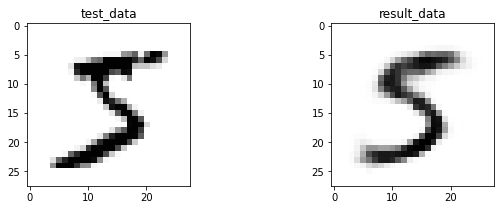

0.937


In [ ]:
cnn1 = torch.load('cnn_minist.pkl')
acc=0
#Coder.decoder.load_state_dict(local_parameters, strict=True)
for i in range(2000):
    #torch.unsqueeze(train_data.train_data[i], dim=1).type(torch.FloatTensor)[:2000]
    test_data = train_data.train_data[i].view(-1,28*28).type(torch.FloatTensor)/255.
    test_data = test_data.to(device)
    resultq = Coder.encoder(test_data)+0.2
    result = Coder.decoder(resultq)
    test_data=test_data.reshape(-1,1,28,28)
    result=result.reshape(-1,1,28,28)
    test1=cnn1(test_data)
    test2=cnn1(result)
    pred_1 = torch.max(test1, 1)[1].cpu().data.numpy()
    pred_2 = torch.max(test2, 1)[1].cpu().data.numpy()
    #print('test_datapre:',pred_1)
    #print('result_datapre:',pred_2)
    if i%2000==0:
        print('test_datapre:',pred_1)
        print('result_datapre:',pred_2)
        im_result = result.view(28,28)
        print(im_result.size())
        plt.figure(1, figsize=(10, 3))
        plt.subplot(121)
        plt.title('test_data')
        plt.imshow(train_data.train_data[i].cpu().numpy(),cmap='Greys')
 
        plt.figure(1, figsize=(10, 3))
        plt.subplot(122)
        plt.title('result_data')
        plt.imshow(im_result.detach().cpu().numpy(), cmap='Greys')
        plt.show()
        plt.pause(0.5)
    if pred_1 == pred_2:
        acc+=1
    else:
        acc=acc
print(acc/2000)
plt.ioff()

In [ ]:
PATH = './drive/My Drive/ganfst_havenoise.pth'
torch.save(Coder.state_dict(), PATH)